In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import optimizers, losses, activations, models, utils
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Input, Dropout, Conv1D, MaxPool1D, Flatten
from sklearn.metrics import f1_score, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/mitbih_train.csv", header=None)
test = pd.read_csv("/content/drive/MyDrive/mitbih_test.csv", header=None)

In [ ]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(train.shape, test.shape)


(87554, 188) (21892, 188)


In [ ]:
print("Train Dataset Information:")
print(train.info())
print("\nTest Dataset Information:")
print(test.info())


Train Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB
None

Test Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21892 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 31.4 MB
None


In [ ]:
print("\nMissing values in Train Dataset:")
print(train.isnull().sum())
print("\nMissing values in Test Dataset:")
print(test.isnull().sum())


Missing values in Train Dataset:
0      0
1      0
2      0
3      0
4      0
      ..
183    0
184    0
185    0
186    0
187    0
Length: 188, dtype: int64

Missing values in Test Dataset:
0      0
1      0
2      0
3      0
4      0
      ..
183    0
184    0
185    0
186    0
187    0
Length: 188, dtype: int64


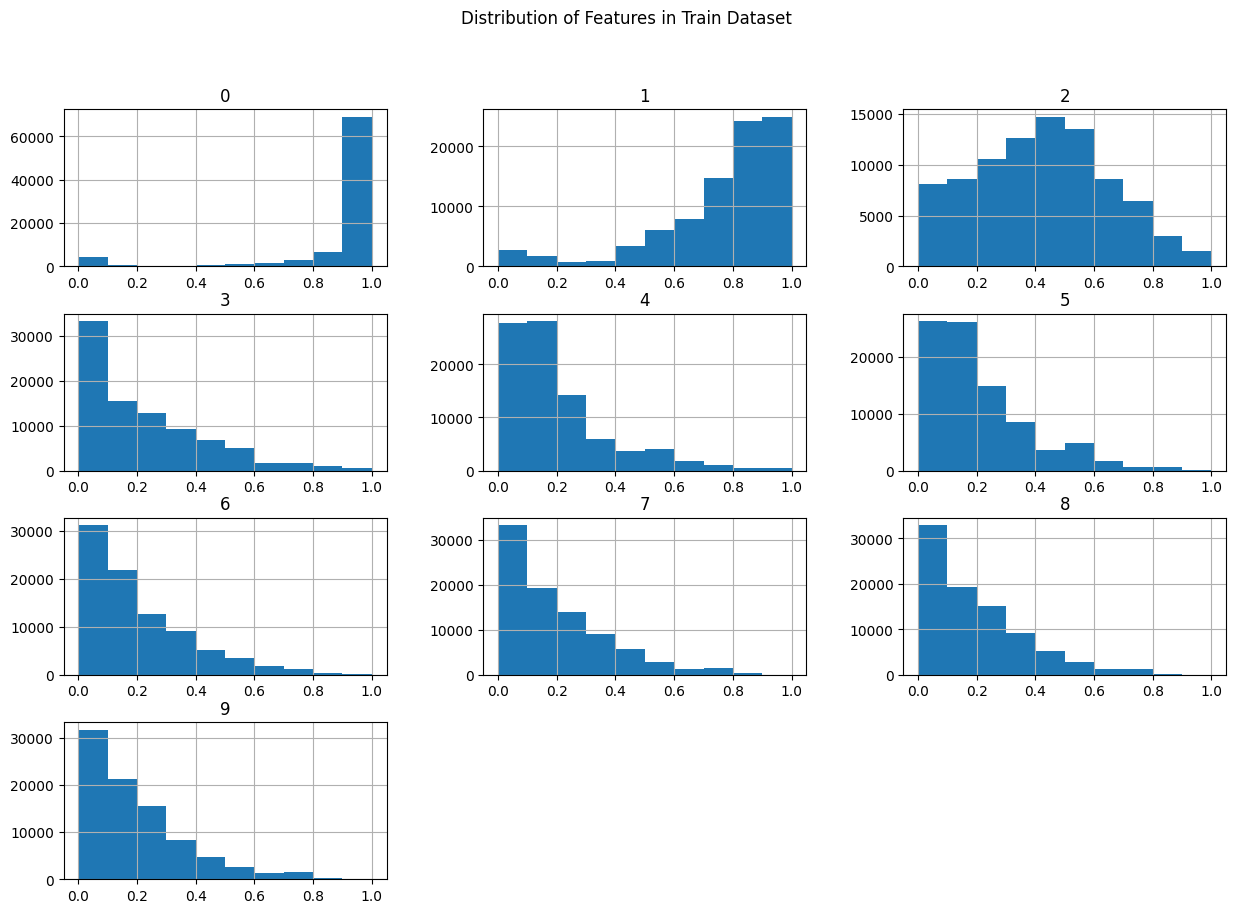

In [ ]:
features_sample = train.columns[:10] # Taking first 10 features as a sample
train[features_sample].hist(figsize=(15, 10))
plt.suptitle("Distribution of Features in Train Dataset")
plt.show()

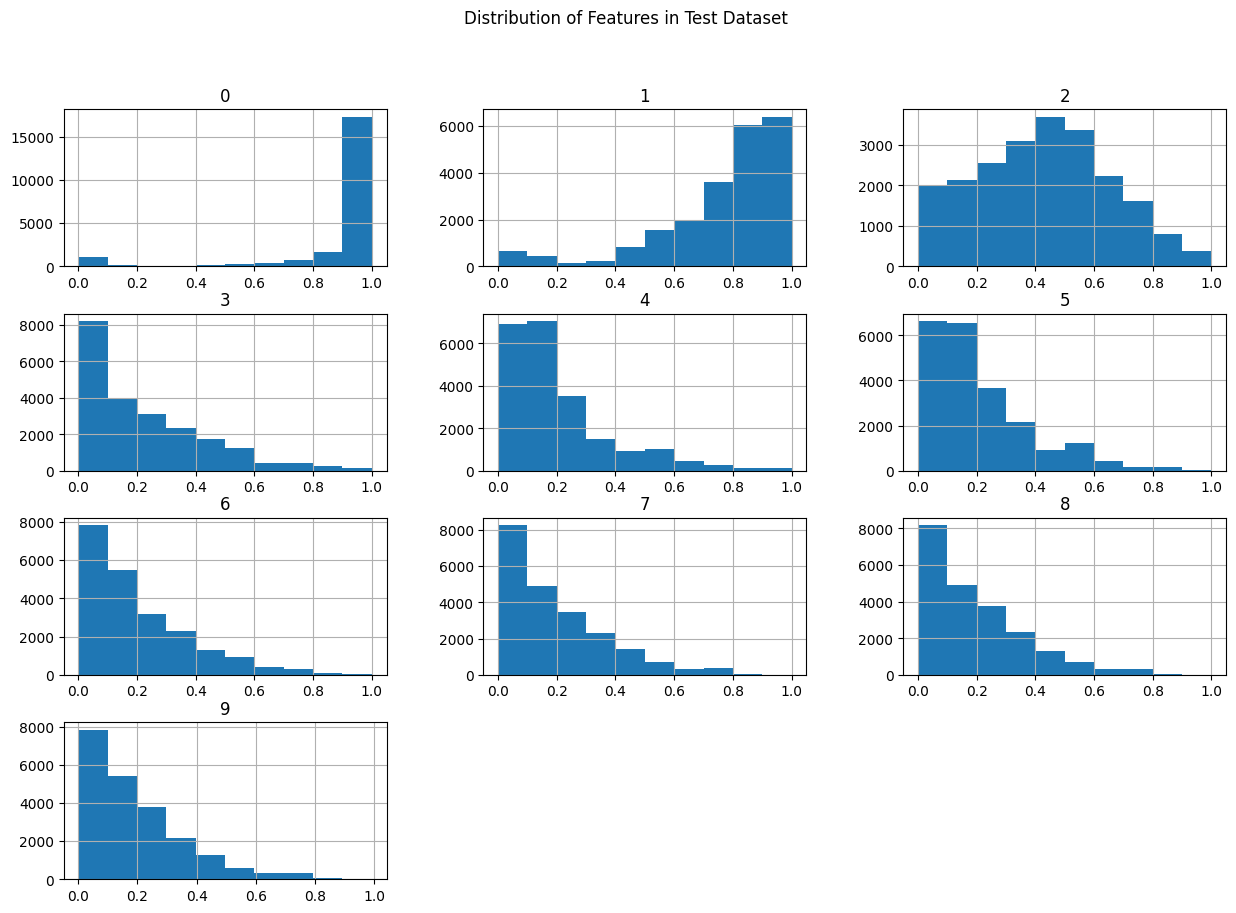

In [ ]:
features_sample = test.columns[:10]
test[features_sample].hist(figsize=(15, 10))
plt.suptitle("Distribution of Features in Test Dataset")
plt.show()

In [ ]:
train.loc[:,187].astype('int').value_counts()

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64

In [ ]:
import plotly.graph_objs as go
# Get the value counts for the target variable
value_counts = train[187].value_counts()
# Create the 3D pie chart
labels = value_counts.index
values = value_counts.values
fig = go.Figure(data=[go.Pie(labels=labels, values=values, pull=[0.1, 0.1, 0.1, 0.1, 0.1])]) # 'pull' gives a 3D effect
fig.update_traces(textinfo='percent+label')
fig.update_layout(title_text="Distribution of Heartbeat Categories in Train Data")
fig.show()

In [ ]:
class_0 = train[train[187] == 0.0].sample(n=8000, replace=True)
class_1 = train[train[187] == 1.0]
class_2 = train[train[187] == 2.0]
class_3 = train[train[187] == 3.0]
class_4 = train[train[187] == 4.0]


In [ ]:
mit = pd.concat([class_0, class_1, class_2, class_3, class_4])
mit.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
2428,0.969589,0.853309,0.592129,0.341682,0.119857,0.001789,0.000000,0.037567,0.062612,0.060823,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
59546,1.000000,0.532646,0.054983,0.144330,0.134021,0.147766,0.127148,0.140893,0.137457,0.144330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5251,0.959770,0.887931,0.525862,0.008621,0.183908,0.321839,0.390805,0.399425,0.419540,0.442529,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
43513,1.000000,0.825843,0.589888,0.373596,0.235955,0.129213,0.056180,0.008427,0.014045,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
47594,1.000000,0.723881,0.206468,0.119403,0.129353,0.084577,0.089552,0.124378,0.116915,0.179104,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


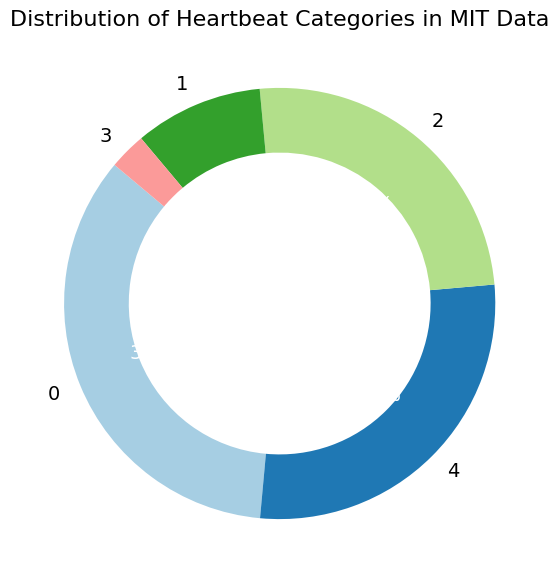

In [ ]:
import matplotlib.pyplot as plt
# Get the value counts for the target variable in the 'mit' DataFrame
value_counts_mit = mit[187].value_counts()
# Data for the doughnut chart
labels_mit = value_counts_mit.index
values_mit = value_counts_mit.values
# Colors for the categories
colors = plt.cm.Paired(range(len(labels_mit)))
# Plotting the doughnut chart
plt.figure(figsize=(10, 7))
wedges, texts, autotexts = plt.pie(values_mit, labels=labels_mit, colors=colors,
autopct='%1.1f%%', startangle=140,
wedgeprops=dict(width=0.3))
plt.title("Distribution of Heartbeat Categories in MIT Data", fontsize=16)
# Improve appearance of texts and autotexts
for text in texts:
  text.set(size=14, color='black')
for autotext in autotexts:
  autotext.set(size=14, color='white')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(mit.drop([187], axis=1), mit[187], test_size = 0.2)

In [ ]:
X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential,utils
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPool1D, Dropout

In [ ]:
clf = tf.keras.Sequential([
Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(X_train.shape[1],1)),
Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'),
MaxPool1D(pool_size=3, strides=2, padding='same'),
Dropout(0.5),
Flatten(),
Dense(units=512, activation='relu'),
Dense(units=1024, activation='relu'),
Dense(units=5, activation='softmax')
])

In [ ]:
clf.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Assuming 'model' is your trained TensorFlow model
clf.save("model.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [ ]:
from google.colab import files

files.download("model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
history = clf.fit(X_train, y_train, epochs=5,
                  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)])

# Additional code, if needed


Epoch 1/5
578/578 [==============================] - 96s 163ms/step - loss: 0.3959 - accuracy: 0.8610
Epoch 2/5
578/578 [==============================] - 96s 167ms/step - loss: 0.2100 - accuracy: 0.9274
Epoch 3/5
578/578 [==============================] - 94s 163ms/step - loss: 0.1556 - accuracy: 0.9458
Epoch 4/5
578/578 [==============================] - 95s 164ms/step - loss: 0.1243 - accuracy: 0.9579
Epoch 5/5
578/578 [==============================] - 101s 176ms/step - loss: 0.1039 - accuracy: 0.9630


In [ ]:
y_pred = clf.predict(X_test)

145/145 [==============================] - 7s 44ms/step


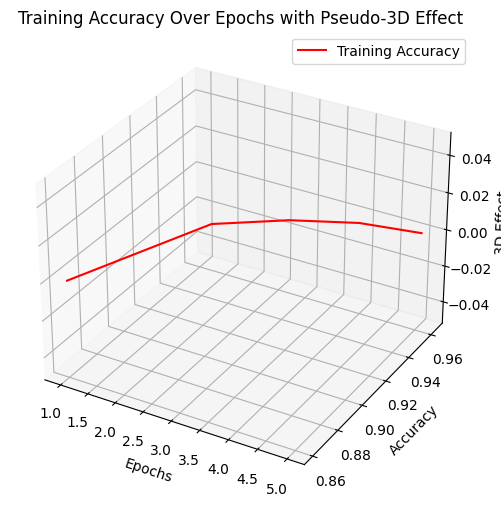

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Extract accuracy and epochs from the history object
acc = history.history['accuracy']
epochs = list(range(1, len(acc) + 1))
# Create a new figure
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
# Plot the data: the z-values are all zero to keep the line on the "floor"
ax.plot(epochs, acc, zs=0, zdir='z', c='r', label='Training Accuracy')
# Set labels and title
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_zlabel('3D Effect') # Just a dummy axis for 3D effect
ax.set_title('Training Accuracy Over Epochs with Pseudo-3D Effect')
ax.legend()
# Display the plot
plt.show()
# Save the figure
fig.savefig("train-accuracy-3d-matplotlib.jpg")

In [ ]:
from sklearn import metrics
y_lbl = [np.where(i == np.max(i))[0][0] for i in y_pred]
print("Train Accuracy: {0:.3f}".format(metrics.accuracy_score(y_lbl, y_test)))


Train Accuracy: 0.965


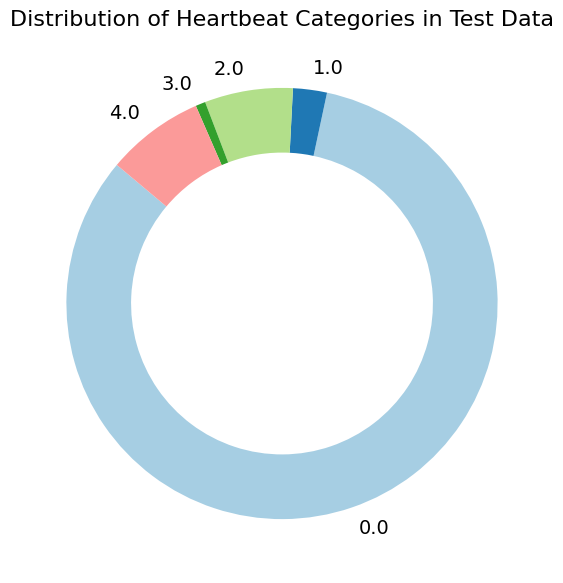

In [ ]:
import matplotlib.pyplot as plt
# Get the value counts for the target variable in the 'test' DataFrame
value_counts_test = test[187].value_counts().sort_index()
# Data for the doughnut chart
labels_test = value_counts_test.index
values_test = value_counts_test.values
# Colors for the categories
colors = plt.cm.Paired(range(len(labels_test)))
# Plotting the doughnut chart
plt.figure(figsize=(10, 7))
wedges, texts, autotexts = plt.pie(values_test, labels=labels_test, colors=colors,
autopct='%1.1f%%', startangle=140,
wedgeprops=dict(width=0.3))
# Enhancing the appearance of texts and autotexts
for text in texts:
  text.set(size=14, color='black')
for autotext in autotexts:
  autotext.set(size=14, color='white')
plt.title("Distribution of Heartbeat Categories in Test Data", fontsize=16)
plt.show()


In [ ]:
test_X = test.drop([187], axis=1)
test_y = test[187]
test_X = np.array(test_X).reshape(test_X.shape[0], test_X.shape[1], 1)

In [ ]:
test_pred_y = clf.predict(test_X)


685/685 [==============================] - 24s 35ms/step


In [ ]:
test_lbl_y = [np.where(i == np.max(i))[0] for i in test_pred_y]
print("Test Accuracy: {0:.3f}".format(metrics.accuracy_score(test_lbl_y, test_y)))

Test Accuracy: 0.962


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_lbl_y, test_y))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     17615
           1       0.80      0.63      0.70       704
           2       0.97      0.82      0.89      1717
           3       0.78      0.62      0.69       205
           4       0.99      0.97      0.98      1651

    accuracy                           0.96     21892
   macro avg       0.90      0.80      0.85     21892
weighted avg       0.96      0.96      0.96     21892



In [ ]:
report = classification_report(test_lbl_y, test_y, output_dict=True)


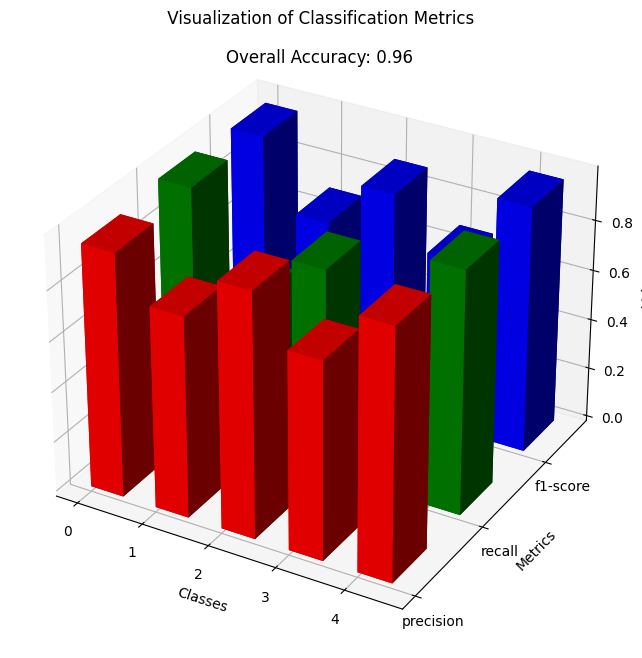

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
# Extract data from the report
classes = list(report.keys())[:-3] # Get the class labels
metrics = ['precision', 'recall', 'f1-score']
values = [[report[cls][metric] for cls in classes] for metric in metrics]
accuracy = report['accuracy']
# Create 3D bar chart
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['r', 'g', 'b'] # Assigning colors for each metric
# Defining the width and depth of the bars
dx = 0.5
dy = 0.5
for metric_index, metric in enumerate(metrics):
  xpos = [i for i in range(len(classes))]
  ypos = [metric_index] * len(classes)
  zpos = [0] * len(classes)
  dz = values[metric_index]
  ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors[metric_index], shade=True)
ax.set_xticks([i for i in range(len(classes))])
ax.set_xticklabels(classes)
ax.set_yticks([i for i in range(len(metrics))])
ax.set_yticklabels(metrics)
ax.set_xlabel('Classes')
ax.set_ylabel('Metrics')
ax.set_zlabel('Value')
ax.set_title(' Visualization of Classification Metrics')
# Adjusting the position of the accuracy text to be just below the title
ax.text2D(0.35, 0.95, f"Overall Accuracy: {accuracy:.2f}", transform=ax.transAxes, fontsize=12, color='black')
plt.show()

In [ ]:
pip install Flask


In [ ]:
from flask import Flask, render_template, request
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import sequence

app = Flask(__name__)

# Load your trained CNN model
model = load_model('/content/model.h5')

@app.route('/')
def index():
    return render_template('/content/index.html')

@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Get ECG data from the form
        ecg_data = request.form['ecg_data']

        # Preprocess the data (you may need to adapt this based on your model's input requirements)
        processed_data = preprocess_ecg_data(ecg_data)

        # Make a prediction
        prediction = make_prediction(processed_data)

        # Render the result page
        return render_template('/content/result.html', ecg_data=ecg_data, prediction=prediction)

    except Exception as e:
        return str(e)

def preprocess_ecg_data(ecg_data):
    # Implement your data preprocessing logic here
    # For example, you might convert the data to a suitable format for your model
    # You may also need to handle data validation and ensure it matches the input requirements of your model
    # This is a placeholder function, replace it with your actual preprocessing code
    processed_data = np.array([float(value) for value in ecg_data.split(',')])

    # Assuming your model expects sequences of a certain length
    processed_data = sequence.pad_sequences([processed_data], maxlen=your_sequence_length)

    return processed_data

def make_prediction(processed_data):
    # Make a prediction using the loaded model
    prediction = model.predict(processed_data)

    # You may need to post-process the prediction based on your model's output format
    # This is a placeholder function, replace it with your actual post-processing code
    return prediction

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
